In [1]:
import sys
sys.path.append('/home2/ebrahim/beyond-brainscore/analyze_results/figures_code/')
from trained_untrained_results_funcs import find_best_layer,load_mean_sem_perf, loop_through_datasets
import numpy as np
from matplotlib import pyplot as plt


In [2]:
exp = ['243', '384']

br_labels_dict = {}
num_vox_dict = {}
subjects_dict = {}

data_processed_folder_pereira = f'/data/LLMs/data_processed/pereira/dataset'
data_processed_folder_fed = f'/data/LLMs/data_processed/fedorenko/dataset'
data_processed_folder_blank = f'/data/LLMs/data_processed/blank/dataset'

subjects_storage = {}
network_labels_storage = {}
lang_indices = {}

for e in exp:

    bre = np.load(f'{data_processed_folder_pereira}/networks_{e}.npy', allow_pickle=True)
    network_labels_storage[f"pereira{e}"]  = bre.squeeze()
    num_vox_dict[e] = bre.shape[0]
    subjects_storage[f"pereira{e}"] = np.load(f"{data_processed_folder_pereira}/subjects_{e}.npy", allow_pickle=True).squeeze()
    lang_indices[e] = np.argwhere(bre=='language').squeeze()

subjects_storage['fedorenko']  = np.load(f"{data_processed_folder_fed}/subjects.npy", allow_pickle=True)
subjects_storage['blank'] = np.load(f"{data_processed_folder_blank}/subjects.npy", allow_pickle=True)

network_labels_storage['fedorenko'] = None
network_labels_storage['blank'] = None

subjects_arr_pereira = np.load(f"{data_processed_folder_pereira}/subjects_complete.npy", allow_pickle=True)
networks_arr_pereira = np.load(f"{data_processed_folder_pereira}/network_complete.npy", allow_pickle=True)

resultsPath_base = '/data/LLMs/brainscore/'

metrics = ['pearson_r', 'out_of_sample_r2']

### For GPT2 and OASM, the best layer is found in the figure1.py file and saved into a dictionary for future use

# Pereira

In [42]:
best_gpt2xl = np.load('/home2/ebrahim/beyond-brainscore/analyze_results/figures_code/best_layer_sigma_info/best_gpt2xl_layer.npz')
for fe in ['', '-mp', '-sp']:
    for exp in ['243', '384']:
        print(fe, exp)
        print(best_gpt2xl[f'pereira_{exp}_pearson_r_contig{fe}'])

 243
15
 384
21
-mp 243
16
-mp 384
21
-sp 243
16
-sp 384
16


In [11]:
def find_best_layer_pereira(model_name, layer_arr, feature_extraction_arr, metrics_arr, 
                            resultsPath_pereira='/data/LLMs/brainscore/results_pereira/',
                            niter=1, lang_only=False, save_path="/home2/ebrahim/beyond-brainscore/analyze_results/figures_code/best_layer_sigma_info"):
    
    
    save_best_layer_dict = {}
    for d, fe, exp, subjects, network in loop_through_datasets(['pereira', 'fedorenko', 'blank'], feature_extraction_arr, lang_only=lang_only):

        for m in metrics_arr:
            for fe in feature_extraction_arr:
            
                lang_indices = np.argwhere(network=='language').squeeze()
                
                _, best_layer, _ = find_best_layer(layer_arr, exp=exp, resultsPath=f'/data/LLMs/brainscore/results_{d}/', subjects=subjects, dataset=d, perf=m, 
                                    selected_network_indices = lang_indices, feature_extraction = fe, model_name=model_name, seed_number=None, 
                                    return_SE=False, niter=niter)
                
                save_best_layer_dict[f"{d}{exp}_{m}_contig{fe}"] = best_layer
                
    
    np.savez(f"{save_path}/{model_name}", **save_best_layer_dict)
    
find_best_layer_pereira('roberta-large', np.arange(25), ['', '-mp', '-sp'], ['pearson_r', 'out_of_sample_r2'], lang_only=True)
find_best_layer_pereira('Llama-3.2-3B-Instruct', np.arange(29), ['', '-mp', '-sp'], ['pearson_r', 'out_of_sample_r2'], lang_only=True)
find_best_layer_pereira('rwkv-4-3b-pile', np.arange(33), ['', '-mp', '-sp'], ['pearson_r', 'out_of_sample_r2'], lang_only=True)

In [45]:
store_perf_pereira = {}
metrics = ['out_of_sample_r2']
for d, fe, exp, subjects, network in loop_through_datasets(['pereira'], ['', '-mp', '-sp']):

    for m in metrics:
        
        if d == 'pereira':
            lang_indices = np.argwhere(network=='language').squeeze()
        else:
            lang_indices = None
            
        e = exp.strip('_')
        
            
        pwr_values = np.round(np.arange(0, 4.8, 0.1),2)
        pwr_values[0] = 0.0

        layer_perf_dict_PWR, bl, _  = find_best_layer(pwr_values, '', exp=exp, resultsPath=f'/data/LLMs/brainscore/results_{d}/', 
                                                                            subjects=subjects_storage[f'{d}{e}'], dataset=d, perf=m, 
                            selected_network_indices = lang_indices, feature_extraction = '', model_name='position', seed_number=None, 
                            return_SE=False, niter=1)
        
        store_perf_pereira[f"PWR_{m}_{e}"] = bl

        e = exp.strip('_')

        if fe != '':
            layer_perf_dict_glove, bl, _ = find_best_layer([0], '', exp=exp, resultsPath=f'/data/LLMs/brainscore/results_{d}/', 
                                                                                subjects=subjects_storage[f'{d}{e}'], dataset=f'{d}', perf=m, 
                                selected_network_indices = lang_indices, feature_extraction = '', model_name=f'glove{fe}', seed_number=None, 
                                return_SE=False, niter=1)
            
            store_perf_pereira[f"Glove_{m}_{e}_{fe}"] = layer_perf_dict_glove[0]
        
        
        layer_perf_dict_gpt2xl_syntax, bl_syntax, _ = find_best_layer(np.arange(48), '', exp=exp, resultsPath=f'/data/LLMs/brainscore/results_{d}/', 
                                                                            subjects=subjects_storage[f'{d}{e}'], dataset=f'{d}', perf=m, 
                            selected_network_indices = lang_indices, feature_extraction = '', model_name=f'gpt2xl-syntax{fe}', seed_number=None, 
                            return_SE=False, niter=1)
        
        store_perf_pereira[f"GPT2XL-syntax_{m}_{e}{fe}"] = bl_syntax

        '''
        layer_perf_dict_gpt2xl_decontext, bl_decontext, _ = find_best_layer(np.arange(48), '', exp=exp, resultsPath=f'/data/LLMs/brainscore/results_{d}/', 
                                                                            subjects=subjects_storage[f'{d}{e}'], dataset=f'{d}', perf=m, 
                            selected_network_indices = lang_indices, feature_extraction = '', model_name=f'gpt2-xl-decontext{fe}', seed_number=None, 
                            return_SE=False, niter=1)

        layer_perf_dict_reg_decontext_banded, _, _ = find_best_layer([1], '', exp=exp, resultsPath=f'/data/LLMs/brainscore/results_{d}/', 
                                                                    subjects=subjects_storage[f'{d}{e}'], dataset=f'{d}', perf=m, 
                    selected_network_indices = lang_indices, feature_extraction = '', model_name=f'gpt2xl-decontext_position{exp}{fe}_pearsonr', seed_number=None, 
                    return_SE=False, niter=1000)
        
        layer_perf_dict_reg, bl_reg, _ = find_best_layer(np.arange(48), '', exp=exp, resultsPath=f'/data/LLMs/brainscore/results_{d}/', 
                                                                            subjects=subjects_storage[f'{d}{e}'], dataset=f'{d}', perf=m, 
                            selected_network_indices = lang_indices, feature_extraction = '', model_name=f'gpt2-xl{fe}', seed_number=None, 
                            return_SE=False, niter=1)
                            
        
        
        '''
        

       

In [46]:
store_perf_pereira

{'PWR_out_of_sample_r2_243': 2.9,
 'GPT2XL-syntax_out_of_sample_r2_243': 12,
 'PWR_out_of_sample_r2_384': 3.4,
 'GPT2XL-syntax_out_of_sample_r2_384': 19,
 'Glove_out_of_sample_r2_243_-mp': 0.0028673114162520307,
 'GPT2XL-syntax_out_of_sample_r2_243-mp': 12,
 'Glove_out_of_sample_r2_384_-mp': 0.01246861708365666,
 'GPT2XL-syntax_out_of_sample_r2_384-mp': 16,
 'Glove_out_of_sample_r2_243_-sp': 0.016240908388800095,
 'GPT2XL-syntax_out_of_sample_r2_243-sp': 7,
 'Glove_out_of_sample_r2_384_-sp': 0.010924025079621973,
 'GPT2XL-syntax_out_of_sample_r2_384-sp': 16}

In [13]:
np.savez("/home2/ebrahim/beyond-brainscore/analyze_results/figures_code/best_layer_sigma_info/best_layer_other_pereira", **store_perf_pereira)

In [25]:
print((0.08551417674953365 + 0.1017423560730531)/2, (0.12656432497725298 + 0.09889899757099453)/2)

0.09362826641129338 0.11273166127412376


# Fedorenko

Best layer Fed feature space:  4.3


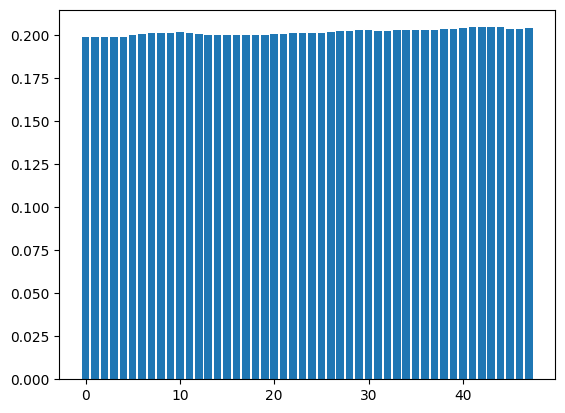

Best layer Fed feature space:  4.7


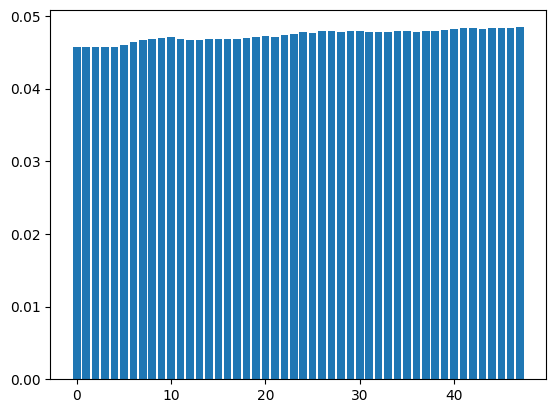

In [12]:
layer_perf_pos_fed = []
for i in np.round(np.arange(0, 4.8, 0.1),2):
    perf_mean = load_mean_sem_perf('pos', 'fedorenko', '', i, niter=1, return_mean=True, print_res=False, perf='pearson_r')
    layer_perf_pos_fed.append(perf_mean)

plt.bar(np.arange(len(layer_perf_pos_fed)), layer_perf_pos_fed)
print("Best layer Fed feature space: ", np.round(np.arange(0, 4.8, 0.1),2)[np.argmax(layer_perf_pos_fed)])
plt.show()

layer_perf_pos_fed = []
for i in np.round(np.arange(0, 4.8, 0.1),2):
    perf_mean = load_mean_sem_perf('pos', 'fedorenko', '', i, niter=1, return_mean=True, print_res=False, perf='out_of_sample_r2')
    layer_perf_pos_fed.append(perf_mean)

plt.bar(np.arange(len(layer_perf_pos_fed)), layer_perf_pos_fed)
print("Best layer Fed feature space: ", np.round(np.arange(0, 4.8, 0.1),2)[np.argmax(layer_perf_pos_fed)])

In [17]:
for fe in ['', '-mp', '-sp']:
    print(fe)
    print(best_gpt2xl[f'fedorenko_pearson_r_contig{fe}'])


25
-mp
25
-sp
21


# Blank

In [13]:
layer_perf_dict, best_layer_blank, layer_perf_best  = find_best_layer(np.arange(3,51), '', '', resultsPath='/data/LLMs/brainscore/results_blank/', subjects=subjects_storage['blank'],
                        dataset='blank', perf='out_of_sample_r2', 
                    selected_network_indices = None, feature_extraction = '', model_name='pos-WN', seed_number=None, 
                    return_SE=False, niter=1)

print("Best layer Blank simple feature space: ", best_layer_blank)

layer_perf_dict, best_layer_blank, layer_perf_best  = find_best_layer(np.arange(3,51), '', '', resultsPath='/data/LLMs/brainscore/results_blank/', subjects=subjects_storage['blank'],
                        dataset='blank', perf='pearson_r', 
                    selected_network_indices = None, feature_extraction = '', model_name='pos-WN', seed_number=None, 
                    return_SE=False, niter=1)

print("Best layer Blank simple feature space: ", best_layer_blank)

Best layer Blank simple feature space:  11
Best layer Blank simple feature space:  12


In [18]:
for fe in ['', '-mp', '-sp']:
    print(fe)
    print(best_gpt2xl[f'blank_pearson_r_contig{fe}'])


2
-mp
3
-sp
2
